This notebook explores the efficiency of Deep Q-Network Agent in a PACMAN Environment. All the dependencies required to run this .ipynb file are present in the code itself.

## Helper Functions
This part contains the code for all the helper fucntions that will be used in the further developement of models.



In [92]:
#This code is written by @sracaniere from DeepMind
#https://github.com/sracaniere

import numpy as np
import math

STANDARD_MAP = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


def get_random_position(map_array):
  """Gets a random available position in a binary map array.

  Args:
    map_array: numpy array of the map to search an available position on.

  Returns:
    The chosen random position.

  Raises:
    ValueError: if there is no available space in the map.
  """
  if map_array.sum() <= 0:
    raise ValueError("There is no available space in the map.")
  map_dims = len(map_array.shape)
  pos = np.zeros(map_dims, dtype=np.int32)
  while True:
    result = map_array
    for i in range(map_dims):
      pos[i] = np.random.randint(map_array.shape[i])
      result = result[pos[i]]
    if result == 0:
      break
  return pos


def update_2d_pos(array_map, pos, action, pos_result):
  posv = array_map[pos[0]][pos[1]][action - 1]
  pos_result[0] = posv[0]
  pos_result[1] = posv[1]
  return pos_result


def parse_map(map_array):
  """Parses a map when there are actions: stay, right, up, left, down.

  Args:
    map_array: 2D numpy array that contains the map.

  Returns:
    A 3D numpy array (height, width, actions) that contains the resulting state
    for a given position + action, and a 2D numpy array (height, width) with the
    walls of the map.

  Raises:
    ValueError: if the map does not contain only zeros and ones.
  """
  act_def = [[0, 0], [0, 1], [-1, 0], [0, -1], [1, 0]]
  walls = np.zeros_like(map_array)
  new_map_array = []
  for i in range(map_array.shape[0]):
    new_map_array.append([])
    for j in range(map_array.shape[1]):
      new_map_array[i].append([])
      if map_array[i, j] == 0:
        for k in range(len(act_def)):
          new_map_array[i][j].append([i + act_def[k][0], j + act_def[k][1]])
      elif map_array[i, j] == 1:
        for k in range(len(act_def)):
          new_map_array[i][j].append([i, j])
        walls[i, j] = 1
      else:
        raise ValueError("Option not understood, %d" % map_array[i, j])
      for k in range(len(new_map_array[i][j])):
        if map_array[new_map_array[i][j][k][0]][new_map_array[i][j][k][1]] == 1:
          new_map_array[i][j][k][0] = i
          new_map_array[i][j][k][1] = j
  return np.array(new_map_array), walls


def observation_as_rgb(obs):
  """Reduces the 6 channels of `obs` to 3 RGB.

  Args:
    obs: the observation as a numpy array.

  Returns:
    An RGB image in the form of a numpy array, with values between 0 and 1.
  """
  height = obs.shape[0]
  width = obs.shape[1]
  rgb = np.zeros((height, width, 3), dtype=np.float32)
  for x in range(height):
    for y in range(width):
      if obs[x, y, PillEater.PILLMAN] == 1:
        rgb[x, y] = [0, 1, 0]
      elif obs[x, y, PillEater.GHOSTS] > 0. or obs[x, y, PillEater.GHOSTS_EDIBLE] > 0.:
        g = obs[x, y, PillEater.GHOSTS]
        ge = obs[x, y, PillEater.GHOSTS_EDIBLE]
        rgb[x, y] = [g + ge, ge, 0]
      elif obs[x, y, PillEater.PILL] == 1:
        rgb[x, y] = [0, 1, 1]
      elif obs[x, y, PillEater.FOOD] == 1:
        rgb[x, y] = [0, 0, 1]
      elif obs[x, y, PillEater.WALLS] == 1:
        rgb[x, y] = [1, 1, 1]
  return rgb


class PillEater(object):

  WALLS = 0
  FOOD = 1
  PILLMAN = 2
  GHOSTS = 3
  GHOSTS_EDIBLE = 4
  PILL = 5
  NUM_ACTIONS = 5
  MODES = ('regular', 'avoid', 'hunt', 'ambush', 'rush')

  def __init__(self, mode, frame_cap=3000):
    assert mode in PillEater.MODES
    self.nghosts_init = 1
    self.ghost_speed_init = 0.5
    self.ghost_speed = self.ghost_speed_init
    self.ghost_speed_increase = 0.1
    self.end_on_collect = False
    self.npills = 2
    self.pill_duration = 20
    self.seed = 123
    self.discount = 1
    self.stochasticity = 0.05
    self.obs_is_rgb = True
    self.frame_cap = frame_cap
    self.safe_distance = 5
    map_array = STANDARD_MAP
    self.map, self.walls = parse_map(map_array)
    self.map = np.array(self.map)
    self.nactions = self.map.shape[2]
    self.height = self.map.shape[0]
    self.width = self.map.shape[1]
    self.reverse_dir = (4, 5, 2, 3)
    self.dir_vec = np.array([[0, 1], [-1, 0], [0, -1], [1, 0]])
    self.world_state = dict(
        pillman=self._make_pillman(),
        ghosts=[],
        food=np.zeros(shape=(self.height, self.width), dtype=np.float32),
        pills=[None] * self.npills,
        power=0
    )
    self.nplanes = 6
    self.image = np.zeros(
        shape=(self.height, self.width, self.nplanes), dtype=np.float32)
    self.color_image = np.zeros(shape=(3, self.height, self.width),
                                dtype=np.float32)
    self.frame = 0
    self.reward = 0.
    self.pcontinue = 1.
    self._init_level(1)
    self._make_image()
    self.mode = mode
    self.timer = 0
    if self.mode == 'regular':
      self.step_reward = 0
      self.food_reward = 1
      self.big_pill_reward = 2
      self.ghost_hunt_reward = 5
      self.ghost_death_reward = 0
      self.all_pill_terminate = False
      self.all_ghosts_terminate = False
      self.all_food_terminate = True
      self.timer_terminate = -1
    elif self.mode == 'avoid':
      self.step_reward = 0.1
      self.food_reward = -0.1
      self.big_pill_reward = -5
      self.ghost_hunt_reward = -10
      self.ghost_death_reward = -20
      self.all_pill_terminate = False
      self.all_ghosts_terminate = False
      self.all_food_terminate = True
      self.timer_terminate = 128
    elif self.mode == 'hunt':
      self.step_reward = 0
      self.food_reward = 0
      self.big_pill_reward = 1
      self.ghost_hunt_reward = 10
      self.ghost_death_reward = -20
      self.all_pill_terminate = False
      self.all_ghosts_terminate = True
      self.all_food_terminate = False
      self.timer_terminate = -1
    elif self.mode == 'ambush':
      self.step_reward = 0
      self.food_reward = -0.1
      self.big_pill_reward = 0
      self.ghost_hunt_reward = 10
      self.ghost_death_reward = -20
      self.all_pill_terminate = False
      self.all_ghosts_terminate = True
      self.all_food_terminate = False
      self.timer_terminate = -1
    elif self.mode == 'rush':
      self.step_reward = 0
      self.food_reward = -0.1
      self.big_pill_reward = 10
      self.ghost_hunt_reward = 0
      self.ghost_death_reward = 0
      self.all_pill_terminate = True
      self.all_ghosts_terminate = False
      self.all_food_terminate = False
      self.timer_terminate = -1

  def _make_pillman(self):
    return self._make_actor(0)

  def _make_enemy(self):
    return self._make_actor(self.safe_distance)

  def _make_actor(self, safe_distance):
    """Creates an actor.

    An actor is a `ConfigDict` with a positions `pos` and a direction `dir`.
    The position is an array with two elements, the height and width. The
    direction is an integer representing the direction faced by the actor.

    Args:
      safe_distance: a `float`. The minimum distance from Pillman.

    Returns:
      A `ConfigDict`.
    """
    actor = {}
    if safe_distance > 0:
      occupied_map = np.copy(self.walls)

      from_ = (self.world_state['pillman']['pos'] - np.array(
          [self.safe_distance, self.safe_distance]))
      to = (self.world_state['pillman']['pos'] + np.array(
          [self.safe_distance, self.safe_distance]))
      from_[0] = max(from_[0], 1)
      from_[1] = max(from_[1], 1)
      to[0] = min(to[0], occupied_map.shape[0])
      to[1] = min(to[1], occupied_map.shape[1])

      occupied_map[from_[0]:to[0], from_[1]:to[1]] = 1

      actor['pos'] = get_random_position(occupied_map)
      actor['dir'] = np.random.randint(4)
    else:
      actor['pos'] = get_random_position(self.walls)
      actor['dir'] = np.random.randint(4)

    return actor

  def _make_pill(self):
    pill = dict(
        pos=get_random_position(self.walls)
    )
    return pill

  def _init_level(self, level):
    """Initialises the level."""
    self.level = level
    self._fill_food(self.walls, self.world_state['food'])
    self.world_state['pills'] = [self._make_pill() for _ in range(self.npills)]
    self.world_state['pillman']['pos'] = get_random_position(self.walls)

    self.nghosts = int(self.nghosts_init + math.floor((level - 1) / 2))
    self.world_state['ghosts'] = [self._make_enemy() for _ in range(self.nghosts)]
    self.world_state['power'] = 0

    self.ghost_speed = (
        self.ghost_speed_init + self.ghost_speed_increase * (level - 1))
    self.timer = 0

  def _fill_food(self, walls, food):
    food.fill(-1)
    food *= walls
    food += 1
    self.nfood = food.sum()

  def _get_food(self, posx, posy):
    self.reward += self.food_reward
    self.world_state['food'][posx][posy] = 0
    self.nfood -= 1
    if self.nfood == 0 and self.all_food_terminate:
      self._init_level(self.level + 1)

  def _get_pill(self, pill_index):
    self.world_state['pills'].pop(pill_index)
    self.reward += self.big_pill_reward
    self.world_state['power'] = self.pill_duration
    if (not self.world_state['pills']) and self.all_pill_terminate:
      self._init_level(self.level + 1)

  def _kill_ghost(self, ghost_index):
    self.world_state['ghosts'].pop(ghost_index)
    self.reward += self.ghost_hunt_reward
    if (not self.world_state['ghosts']) and self.all_ghosts_terminate:
      self._init_level(self.level + 1)

  def _die_by_ghost(self):
    self.reward += self.ghost_death_reward
    self.pcontinue = 0

  def _move_pillman(self, action):
    """Moves Pillman following the action in the proto `action_proto`."""
    action += 1  # our code is 1 based
    pos = self.world_state['pillman']['pos']
    pillman = self.world_state['pillman']
    update_2d_pos(self.map, pos, action, pos)
    if self.world_state['food'][pos[0]][pos[1]] == 1:
      self._get_food(pos[0], pos[1])
    for i, pill in enumerate(self.world_state['pills']):
      pos = pill['pos']
      if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
        self._get_pill(i)
        break

  def _move_ghost(self, ghost):
    """Moves the given ghost."""
    pos = ghost['pos']
    new_pos = np.zeros(shape=(2,), dtype=np.float32)
    pillman = self.world_state['pillman']
    available = []
    for i in range(2, self.nactions + 1):
      update_2d_pos(self.map, pos, i, new_pos)
      if pos[0] != new_pos[0] or pos[1] != new_pos[1]:
        available.append(i)
    n_available = len(available)
    if n_available == 1:
      ghost['dir'] = available[0]
    elif n_available == 2:
      if ghost['dir'] not in available:
        if self.reverse_dir[ghost['dir'] - 2] == available[0]:
          ghost['dir'] = available[1]
        else:
          ghost['dir'] = available[0]
    else:
      rev_dir = self.reverse_dir[ghost['dir'] - 2]
      for i in range(n_available):
        if available[i] == rev_dir:
          available.pop(i)
          n_available -= 1
          break
      prods = np.zeros(n_available, dtype=np.float32)
      x = np.array(
          [pillman['pos'][0] - pos[0], pillman['pos'][1] - pos[1]], dtype=np.float32)
      norm = np.linalg.norm(x)
      if norm > 0:
        x *= 1. / norm
        for i in range(n_available):
          prods[i] = np.dot(x, self.dir_vec[available[i] - 2])
        if self.world_state['power'] == 0:
          if self.stochasticity > np.random.uniform():
            j = np.random.randint(n_available)
          else:
            # move towards pillman:
            j = np.argmax(prods)
        else:
          # run away from pillman:
          j = np.argmin(prods)
        ghost['dir'] = available[j]
    update_2d_pos(self.map, pos, ghost['dir'], pos)

  def _make_image(self):
    """Represents world in a `height x width x 6` `Tensor`."""
    self.image.fill(0)
    self.image[:, :, PillEater.WALLS] = self.walls
    self.image[:, :, PillEater.FOOD] = self.world_state['food']
    self.image[self.world_state['pillman']['pos'][0], self.world_state['pillman']['pos'][1],
               PillEater.PILLMAN] = 1
    for ghost in self.world_state['ghosts']:
      edibility = self.world_state['power'] / float(self.pill_duration)
      self.image[ghost['pos'][0], ghost['pos'][1], PillEater.GHOSTS] = 1. - edibility
      self.image[ghost['pos'][0], ghost['pos'][1], PillEater.GHOSTS_EDIBLE] = edibility
    for pill in self.world_state['pills']:
      self.image[pill['pos'][0], pill['pos'][1], PillEater.PILL] = 1
    return self.image

  def start(self):
    """Starts a new episode."""
    self.frame = 0
    self._init_level(1)
    self.reward = 0
    self.pcontinue = 1
    self.ghost_speed = self.ghost_speed_init
    return self._make_image(), self.reward, self.pcontinue

  def step(self, action):
    """Advances environment one time-step following the given action."""
    self.frame += 1
    pillman = self.world_state['pillman']
    self.pcontinue = self.discount
    self.reward = self.step_reward
    self.timer += 1
    # Update world state
    self.world_state['power'] = max(0, self.world_state['power']-1)

    # move pillman
    self._move_pillman(action)

    for i, ghost in enumerate(self.world_state['ghosts']):
      # first check if pillman went onto a ghost
      pos = ghost['pos']
      if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
        if self.world_state['power'] == 0:
          self._die_by_ghost()
        else:
          self._kill_ghost(i)
          break
      # Then move ghosts
      speed = self.ghost_speed
      if self.world_state['power'] != 0:
        speed *= 0.5
      if np.random.uniform() < speed:
        self._move_ghost(ghost)
        pos = ghost['pos']
        # check if ghost went onto pillman
        if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
          if self.world_state['power'] == 0:
            self._die_by_ghost()
          else:
            self._kill_ghost(i)
            # assume you can only eat one ghost per turn:
            break
    self._make_image()

    # Check if level over
    if self.timer == self.timer_terminate:
      self._init_level(self.level + 1)

    # Check if framecap reached
    if self.frame_cap > 0 and self.frame >= self.frame_cap:
      self.pcontinue = 0

  def observation(self, agent_id=0):
    return (self.reward,
            self.pcontinue,
            observation_as_rgb(self.image))

In [93]:
#This code is from openai baseline
#https://github.com/openai/baselines/tree/master/baselines/common/vec_env

import numpy as np
from multiprocessing import Process, Pipe

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()


class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True

    def __len__(self):
        return self.nenvs

## Pacman Environment
This part of the code contains the code for custom PACMAN environment. We will be comparing the performance of Imagination Augmented Agents and Deep Q-Networks on this environment in the further sections.

In [94]:
!pip install gym

In [95]:
import gym
from gym import spaces


class MiniPacman:
    def __init__(self, mode, frame_cap):
        self.mode      = mode
        self.frame_cap = frame_cap

        self.env = PillEater(mode=mode, frame_cap=frame_cap)

        self.action_space      = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=1.0, shape=(3, 15, 19))

    def step(self, action):
        self.env.step(action)
        env_reward, env_pcontinue, env_frame = self.env.observation()
        self.done = env_pcontinue != 1
        env_frame = env_frame.transpose(2, 0, 1)
        return env_frame, env_reward, self.done, {}

    def reset(self):
        image, _, _ = self.env.start()
        image = observation_as_rgb(image)
        self.done = False
        image = image.transpose(2, 0, 1)
        return image

In [96]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
def displayImage(image, step, reward):
    s = "step" + str(step) + " reward " + str(reward)
    plt.title(s)
    plt.imshow(image)
    plt.show()

In [98]:
keys = {
    'w': 2,
    'd': 1,
    'a': 3,
    's': 4,
    ' ': 0
}

In [99]:
MODES = ('regular', 'avoid', 'hunt', 'ambush', 'rush')
# frame_cap = 1000

# mode = 'rush'

# env = MiniPacman(mode, 1000)

# state = env.reset()
# done = False

# total_reward = 0
# step = 1

# displayImage(state.transpose(1, 2, 0), step, total_reward)

# while not done:
#     x = input()
#     clear_output()
#     try:
#         keys[x]
#     except:
#         print ("Only 'w' 'a' 'd' 's'")
#         continue
#     action = keys[x]

#     next_state, reward, done, _ = env.step(action)
#     total_reward += reward
#     displayImage(next_state.transpose(1, 2, 0), step, total_reward)
#     step += 1


##DQN
This part contains the code for Deep Q-Network Agent which interacts with the PACMAN Environment.

In [100]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline

In [101]:
load_model = False

In [102]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

class Agent():
    def __init__(self, epsilon_decay, epsilon_min,
                       gamma, learning_rate, state_size, action_size,
                       batch_size, training_threshold):
        '''CREATING AND DEFINING BASIC PARAMETERS FOR TRAINING'''
        self.movement_penalty = -1
        # Change epsilon if model is already trained.
        self.epsilon = 0.99
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.learning_rate = learning_rate

        self.state_size = state_size
        self.action_size = action_size

        self.batch_size = batch_size
        self.training_threshold = training_threshold

        # Main Model
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        # Target Model
        self.target_model = DQN(state_size, action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.target_update_counter = 0

        # Replay Memory
        self.replay_memory = deque(maxlen=2000)

    def update_replay_memory(self, state, action, reward, next_state, done):
        '''UPDATING REPLAY MEMORY and DECAYING EPSILON'''
        self.replay_memory.append((state, action, reward, next_state, done))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def select_action(self, state):
        '''DEFINING EPSILON GREEDY STRATEGY'''
        if np.random.rand() > self.epsilon:
            with torch.no_grad():
                q_values = self.model(torch.tensor(state, dtype=torch.float32))
                return np.argmax(q_values.numpy())
        else:
            return np.random.randint(0, self.action_size)

    def train_agent(self):
        '''TRAINING AGENT'''
        if len(self.replay_memory) < self.training_threshold:
            return

        batch_size = min(self.batch_size, len(self.replay_memory))
        minibatch = random.sample(self.replay_memory, batch_size)

        observations = np.zeros((batch_size, self.state_size))
        next_observations = np.zeros((batch_size, self.state_size))

        action = []
        reward = []
        done = []

        for sample_index in range(self.batch_size):
            observations[sample_index] = minibatch[sample_index][0]
            action.append(minibatch[sample_index][1])
            reward.append(minibatch[sample_index][2])
            next_observations[sample_index] = minibatch[sample_index][3]
            done.append(minibatch[sample_index][4])

        current_q_values = self.model(torch.tensor(observations, dtype=torch.float32))
        future_q_values = self.target_model(torch.tensor(next_observations, dtype=torch.float32))

        for index in range(self.batch_size):
            if not done[index]:
                current_q_values[index][action[index]] = reward[index] + self.gamma * torch.max(future_q_values[index]).item()
            else:
                current_q_values[index][action[index]] = reward[index]

        loss = F.mse_loss(current_q_values, future_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if done:
            self.target_update_counter += 1

        if self.target_update_counter > update_target_every:
            self.target_model.load_state_dict(self.model.state_dict())
            self.target_update_counter = 0

## Training the Agent
This part of the code contains the training loop for the DQN agent. The plot of rewards v/s episodes does not show an increasing trend as we had to train the model for a very limited number of episodes due to resource constraints.

In [103]:
num_episodes= 5000
epsilon_decay = 0.999995
epsilon_min = 0.1
gamma = 0.99
learning_rate = 0.001
batch_size = 64
training_threshold = 1000
update_target_every = 10
load_model = False

In [104]:
# Initialize the environment
env = MiniPacman(mode='regular', frame_cap=1000)

# Initialize the agent
agent = Agent(epsilon_decay=epsilon_decay, epsilon_min=epsilon_min,
              gamma=gamma, learning_rate=learning_rate,
              state_size=np.prod(env.observation_space.shape),
              action_size=env.action_space.n,
              batch_size=batch_size, training_threshold=training_threshold)

# Lists to store episode rewards and losses
episode_rewards = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    state = np.reshape(state, [1, agent.state_size])
    total_reward = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, agent.state_size])
        total_reward += reward

        agent.update_replay_memory(state, action, reward, next_state, done)

        state = next_state

        if done:
            break

    episode_rewards.append(total_reward)

    # Train the agent
    agent.train_agent()

    # Print episode information
    if episode % 100 == 0:
        print(f"Episode: {episode}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")



Episode: 100/5000, Total Reward: 22, Epsilon: 0.9535909915187536
Episode: 200/5000, Total Reward: 8, Epsilon: 0.9305630083891768
Episode: 300/5000, Total Reward: 6, Epsilon: 0.9073513265183664
Episode: 400/5000, Total Reward: 5, Epsilon: 0.8818920480716756
Episode: 500/5000, Total Reward: 11, Epsilon: 0.8628230240165585
Episode: 600/5000, Total Reward: 6, Epsilon: 0.8381939578551394
Episode: 700/5000, Total Reward: 17, Epsilon: 0.8096276416467862
Episode: 800/5000, Total Reward: 15, Epsilon: 0.7830913508889686
Episode: 900/5000, Total Reward: 7, Epsilon: 0.7675658754051533
Episode: 1000/5000, Total Reward: 10, Epsilon: 0.7444154134035947
Episode: 1100/5000, Total Reward: 17, Epsilon: 0.7251033269632623
Episode: 1200/5000, Total Reward: 4, Epsilon: 0.7042856958631094
Episode: 1300/5000, Total Reward: 10, Epsilon: 0.6881618338716268
Episode: 1400/5000, Total Reward: 9, Epsilon: 0.6728678681376068
Episode: 1500/5000, Total Reward: 20, Epsilon: 0.6493772903781514
Episode: 1600/5000, Total 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Rewards')

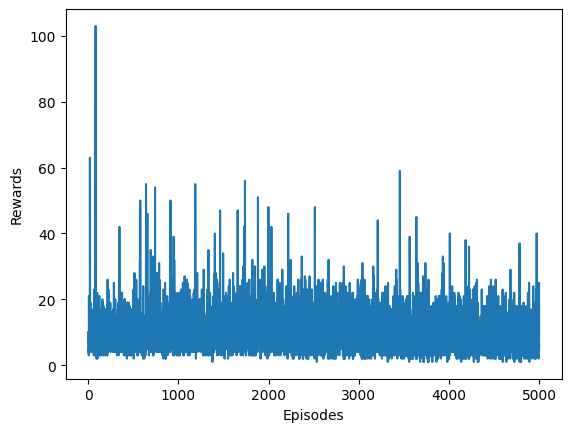

In [107]:
plt.plot(np.arange(0,num_episodes,1), episode_rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')

In [106]:
# Save the model weights
torch.save(agent.model.state_dict(), 'agent_weights.pth')